In [2]:
#This is based on:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8759878
#codebase is from:
# https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

In [3]:
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import os
import sys

In [4]:
#load a testsample
data = sio.loadmat('training/'+'train_ecg_00092'+'.mat')
signal = data['val'].T
print(signal.shape)
signal = np.ravel(signal)
print(signal.shape)
#plt.plot(signal) 
#plt.show()

(9000, 1)
(9000,)


In [5]:
fs = 300

The start and end index are:  900 8100
The new length of the signal is:  7200


<function matplotlib.pyplot.show(close=None, block=None)>

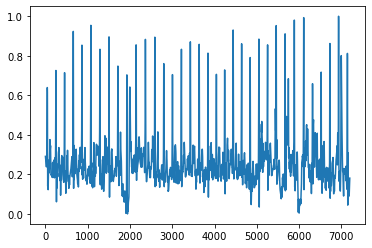

In [6]:
#cutoff the first and last 3 seconds of the signal
startindex = fs * 3 #seconds
endindex = signal.size - startindex
print("The start and end index are: ",startindex, endindex)
cutsignal = signal[startindex:endindex]
print("The new length of the signal is: ",cutsignal.size)

#normalise signalvalues
normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))

#plot the cut and normalised signal
plt.plot(normalisesignal)
plt.show

(257, 32)

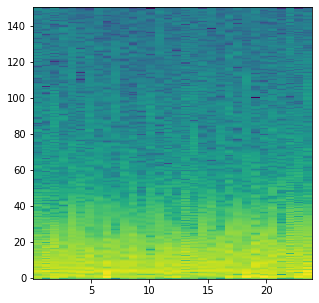

In [7]:
from scipy import signal as siglib
from scipy.fft import fftshift
np.set_printoptions(threshold=sys.maxsize)
#create spectogram of signal
#spectrum, freqs, t, im = plt.specgram(normalisesignal, NFFT=512, Fs=300, norm)

#plt.savefig('testfig.png')
plt.figure(figsize=(5,5))
f,t, Sxx = siglib.spectrogram(normalisesignal, fs=300, nfft=512)


plt.pcolor(t, f, 10*np.log10(Sxx))
Sxx.shape

In [9]:
with open('training/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
        signal = data['val'].T
        signal = np.ravel(signal)
        startindex = fs * 3 #seconds
        endindex = signal.size - startindex
        cutsignal = signal[startindex:endindex]
        normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))
        f,t, Sxx = siglib.spectrogram(normalisesignal, fs=300, nfft=512)
        Sxx = 10*np.log10(Sxx)
        
        if row[1]=='N':                        # Zuordnung zu "Normal"
            if os.path.exists('Preproces/N.npy') and np.load('Preproces/N.npy').shape[3]==1 :
                Narr=np.load('Preproces/N.npy')
                print(Narr.shape)
                Narr=np.stack(Narr,np.expand_dims(Sxx, axis=-1))
                np.save('Preproces/N.npy', Narr) 
            else:
                np.save('Preproces/N.npy', np.expand_dims(Sxx, axis=-1))
       
        if row[1]=='A':                        # Zuordnung zu "Vorhofflimmern"
            if os.path.exists('Preproces/A.npy') and np.load('Preproces/A.npy').shape[3]==1:
                Aarr=np.load('Preproces/A.npy')
                print(Aarr.shape)
                np.stack(Aarr,np.expand_dims(Sxx, axis=-1))
                np.save('Preproces/A.npy', Aarr) 
            else:
                np.save('Preproces/A.npy', np.expand_dims(Sxx, axis=-1))            
        
        del data, signal, cutsignal, normalisesignal, Sxx, f,t
        plt.close()
        
        line_count = line_count + 1
        if (line_count % 100)==0:
            print(str(line_count) + "\t Dateien wurden verarbeitet.")

IndexError: tuple index out of range

In [57]:
Nclass = np.load('Preproces/N.npy')
print(Nclass.shape)

(0,)


In [44]:
print(Nclass.shape)
print(Aclass.shape)

(0,)
(0,)


In [ ]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
 24/103 [=====>........................] - ETA: 4:15 - loss: 0.8208 - accuracy: 0.6237

KeyboardInterrupt: 

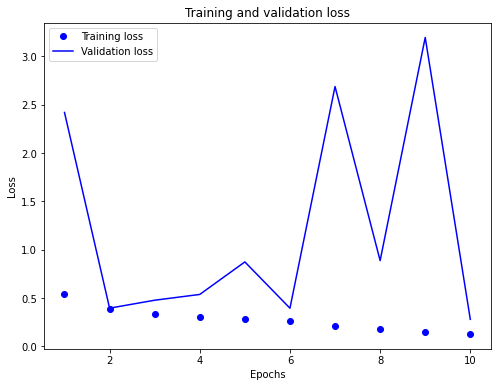

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

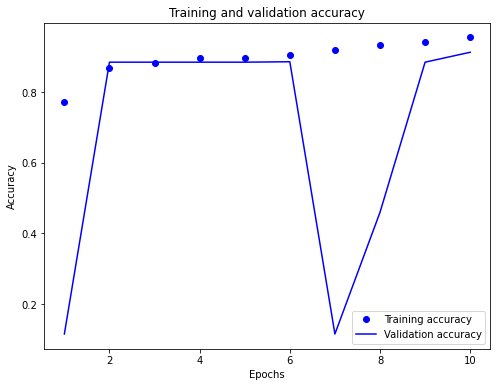

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()